# Feb 1 - Sep 28, 2018

Nutrient comparisons with edited dataset using surface instead of 2m for depth.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import os
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')

In [5]:
nutrients_2015[:4]

,station,num,depth,date,Time,lat,lon,no23,si,po4,flagged
0,CBE2,317,2,26-01-2015,NaN,48.736667,-123.571667,7.47,89.02,0.488,False
1,CBE2,319,20,26-01-2015,NaN,48.736667,-123.571667,25.69,51.65,1.993,False
2,CBW2,375,20,26-01-2015,NaN,48.748333,-123.621667,26.59,50.57,2.105,False
3,CBW2,376,20,26-01-2015,NaN,48.748333,-123.621667,34.11,56.14,2.548,False


In [6]:
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [7]:
nutrients_2015.shape

(896, 13)

In [8]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [9]:
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])

In [10]:
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]

In [11]:
nutrients_2015.shape

(890, 13)

In [12]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(890)])
dates = np.ma.masked_outside(dates, datetime.datetime(2015, 2, 1, 12, 0), 
                             datetime.datetime(2015, 9, 28, 12, 0))
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

In [13]:
list_of_model_si = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_month = np.ma.masked_array(np.zeros(890), mask = True)
t = 0
for n in range(890):
    if dates.mask[n] == False:
        Yind = int(Yinds[n])
        Xind = int(Xinds[n])
        date = dates[n]
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if ((depths[n] == 20) and 
            (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
            ni_val = nuts.variables['nitrate'][0, 18, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = si_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = ni_val
            list_of_month.mask[t] = False
            list_of_month[t] = date.month
        elif ((depths[n] == 2) and 
              (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
            ni_val = nuts.variables['nitrate'][0, 0, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = si_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = ni_val
            list_of_month.mask[t] = False
            list_of_month[t] = date.month
    t = t + 1

In [14]:
np.ma.count(list_of_model_ni)

745

In [16]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [17]:
stations = np.ma.masked_array(stations, mask = list_of_model_si.mask)

In [18]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

bias =  -0.7850607938152816
RMSE = 7.3853682798933065
Willmott = 0.8554311381658772


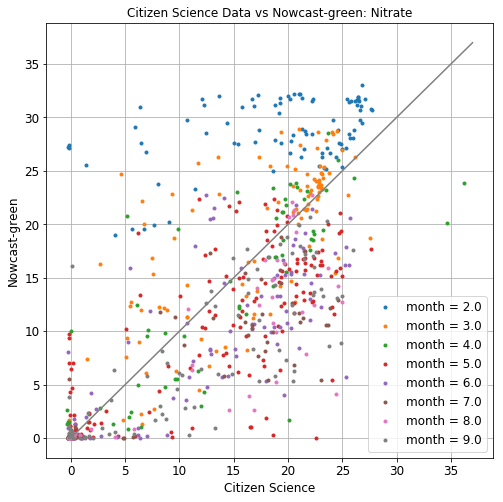

In [25]:
fig, ax = plt.subplots(figsize = (8,8))
for month in np.unique(list_of_month)[:-1]:
    ax.plot(cs_no23[list_of_month == month], list_of_model_ni[list_of_month == month], '.',
            label = 'month = ' + str(month))
ax.plot(np.arange(0,38), np.arange(0,38), '-', color = 'grey')
ax.grid('on')
ax.legend()
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              673)))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  -9.399604354683536
RMSE = 17.91976092011786
Willmott = 0.7202354222283346


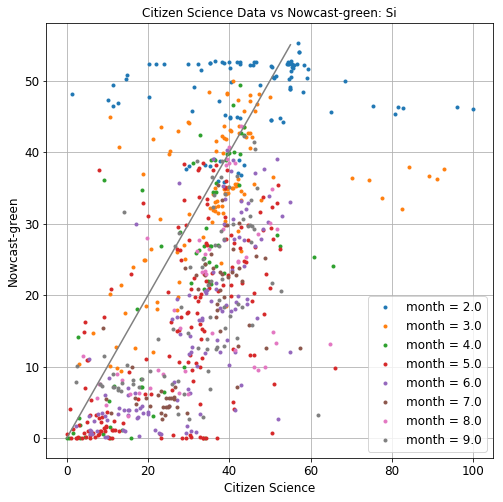

In [26]:
fig, ax = plt.subplots(figsize = (8,8))
for month in np.unique(list_of_month)[:-1]:
    ax.plot(cs_si[list_of_month == month], list_of_model_si[list_of_month == month], '.',
            label = 'month = ' + str(month))
ax.plot(np.arange(0,56), np.arange(0,56), '-', color = 'grey')
ax.grid('on')
plt.legend()
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              673)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

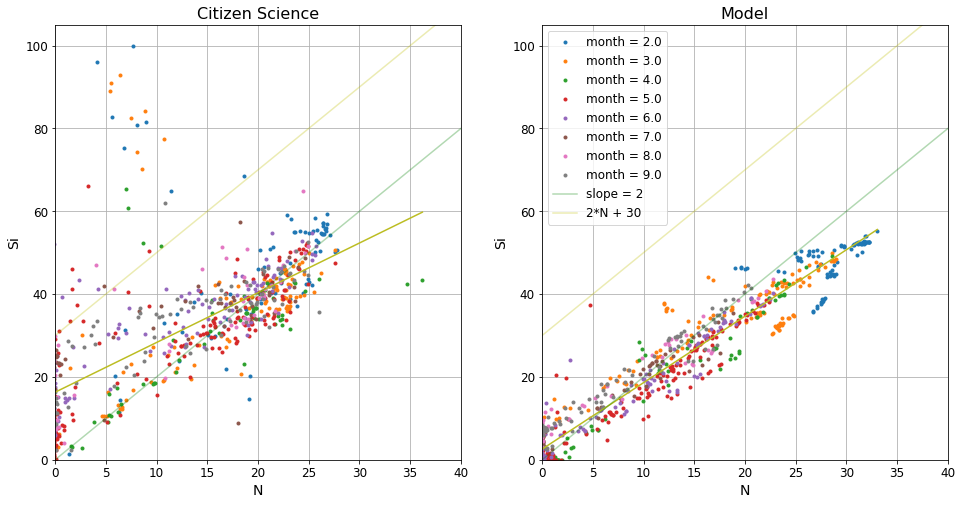

In [27]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
for month in np.unique(list_of_month)[:-1]:
    ax[0].plot(cs_no23[list_of_month == month], cs_si[list_of_month == month], '.',
            label = 'month = ' + str(month))
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
for month in np.unique(list_of_month)[:-1]:
    ax[1].plot(list_of_model_ni[list_of_month == month], list_of_model_si[list_of_month == month], '.',
            label = 'month = ' + str(month))
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [28]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.2008970436490647
CitSci y int = 16.313492575414465
model slope = 1.6047745546464691
model y int = 2.5707618036924003
